In [1]:
%matplotlib inline
import os
import subprocess
import pandas
import numpy
import targeting

# Loading the data
First, we download the connectome dataset from MPG servers. Adjust "local_data_dir" to where you want to put the data (~700 MB), or where you already have the data. 

In [2]:
fileurls = {'dendrites': 'https://l4dense2019.brain.mpg.de/webdav/dendrites.hdf5',
            'synapses': 'https://l4dense2019.brain.mpg.de/webdav/synapses.hdf5',
            'axons': 'https://l4dense2019.brain.mpg.de/webdav/axons.hdf5'}

local_data_dir = '/home/reimann/Documents/data/Helstaedter_connectome'
if not os.path.exists(local_data_dir):
    os.makedirs(local_data_dir)

filenames = dict([(k, os.path.join(local_data_dir, os.path.split(v)[1]))
                 for k, v in fileurls.items()])
for k in filenames.keys():
    if not os.path.exists(filenames[k]):
        print("Downloading {fn}".format(fn=fileurls[k]))
        subprocess.check_call(["wget", "--no-check-certificate", "-O", filenames[k], fileurls[k]])

Now we load the data. We load data for excitatory and inhibitory connections separately. We set min_n_dendrite=10 and min_n_axon=10 to indicate that post- and pre-synaptic fragments with fewer than 10 synapses should be filtered out, as in the Science paper.

In [3]:
data_inh = targeting.Helmstaedter_results(filenames, ['inhibitory'],
                                          min_n_dendrite=10, min_n_axon=10)
data_exc = targeting.Helmstaedter_results(filenames, ['corticocortical', 'thalamocortical'],
                                          min_n_dendrite=10, min_n_axon=10)

Let's get an overview of what we have loaded. Note: The Science paper reports 5,894 excitatory axons and 893 inhibitory axons with 153,171 synapses in total. We do not reach exactly the same numbers, likely because our filtering for a minimum of 10 synapses per fragment was implemented differently. However, our numbers get very close and as you will see later, we can reproduce their panels 4 D, E, F and G.

In [4]:
print(data_inh.res)
print(data_exc.res)
print("""There are {n_exc} synapses from {l_exc} excitatory axons
      and {n_inh} synapses from {l_inh} inhibitory axons""".format(n_exc=data_exc.res.values.sum(),
                                                                   n_inh=data_inh.res.values.sum(),
                                                                  l_exc=len(data_exc),
                                                                  l_inh=len(data_inh)))

     SOM  AIS  SD  AD  PD  OTHER
0      4    0   1   0   3      1
1      0    0   0   1   1      7
2      3    0   0   1   5      2
3      6    0   2   0   3      5
4      2    0   0   0   5      2
5      0    0   0   1   4      6
6      1    0   2   0   1     16
7      4    0   0   0   7      3
8      0    0   0   1   4      7
9      0    0   2   2   7      7
10     0    0   0   1   4      8
11     1    1   1   2  11      8
12     0    0   1   0   0      8
13     4    0   2   2   3      0
14     0    0   1   1   1      9
15     0    0   1   0   7     15
16     0    0   0   1   3      7
17     1    0   2   2   8     24
18     1    1   0   0   3      6
19     1    0   2   4   2     23
20     0    0   2   1   6     20
21     4    0   0   0   5      1
22     0    0   0   3   8     26
23     0    0   0   0   1      9
24     1    0   1  10   2     35
25     4    0   0   0  10     14
26     0    0   2   3   3      4
27     0    0   1   3   4      8
28     4    0   0   0   3      3
29     0  

# Recreating the Science paper results
Let's start by recreating panel 4 D. To plot the results for individual axons, we concatenate the results for excitatory and inhibitory axons (data_inh + data_exc, the plus operator concatenates results) and then normalize each row (.normalized()).

Then, we use the .fit_all function to get the probabilities to target each type of postsynaptic structure. To get the overall means, we use targeting.trivial_fit as fitting function on the concatenated data. For the probabilities estimated under the "first hit" model we use targeting.first_hit_fit for the fit, and we call it on excitatory and inhibitory axons separately.

The probabilities reported for inhibitory axons under the "first hit" model in the Science paper are: 4.2% (Somata), 17.8% (PD), 4.9% (SD), 3.3% (AD), and 0.5% (AIS)

/home/reimann/code/targeting_specificity_test/targeting/specificity.py:21: RuntimeWarning: invalid value encountered in log
  return -numpy.sum(numpy.log(p_zero))


Results of the 'first hit' binomial model fit:
    Excitatory (%):
PD    15.541162
AD     5.002025
SD     6.105558
dtype: float64
    Inhibitory (%):
SOM     3.789727
AIS     0.257699
SD      3.941965
AD      3.551435
PD     18.099864
dtype: float64


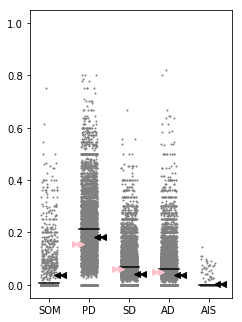

In [5]:
type_to_idx = {'SOM': 0, 'PD': 1, 'SD': 2, 'AD': 3, 'AIS': 4, 'OTHER': -1}
idx_to_type = dict([(v, k) for k, v in type_to_idx.items()])


def plot_a_column(ax, data, column_name):
    base_x = type_to_idx[column_name]
    if base_x < 0:
        return
    y = data[column_name]
    x = base_x + numpy.random.rand(len(y)) * 0.4 - 0.2
    ax.plot(x, y, ls='None', marker='.', color='grey', ms=2)

def plot_mean_column(ax, data_mn, data_fit_exc, data_fit_inh, column_name):
    base_x = type_to_idx[column_name]
    y_mn = data_mn[column_name]
    y_inh = data_fit_inh[column_name]
    ax.plot([base_x - 0.25, base_x + 0.25], [y_mn, y_mn], color='black')
    ax.plot([base_x + 0.35, base_x + 0.2], [y_inh, y_inh], color='black', marker='<')
    if column_name in data_fit_exc:
        y_exc = data_fit_exc[column_name]
        ax.plot([base_x - 0.35, base_x - 0.2], [y_exc, y_exc], color='pink', marker='>')

def fig_4_d(data_exc, data_inh):
    from matplotlib import pyplot as plt
    data_all = data_inh + data_exc
    normalized_all = data_all.normalized()
    data_mn = data_all.fit_all(targeting.trivial_fit)
    data_fit_exc = data_exc.fit_all(targeting.first_hit_fit)
    data_fit_inh = data_inh.fit_all(targeting.first_hit_fit)
    data_fit_exc.pop('OTHER'); data_fit_inh.pop('OTHER')
    print("""Results of the 'first hit' binomial model fit:
    Excitatory (%):\n{res_exc}
    Inhibitory (%):\n{res_inh}""".format(res_exc=str(100*data_fit_exc),
                                   res_inh=str(100*data_fit_inh)))
    ax = plt.figure(figsize=(3.5,5)).add_axes([0.1, 0.1, 0.8, 0.8])
    for col in data_fit_inh.index:
        plot_a_column(ax, normalized_all.res, col)
        plot_mean_column(ax, data_mn, data_fit_exc, data_fit_inh, col)
    idxx = sorted(idx_to_type.keys())
    ax.set_xticks(idxx[1:])
    ax.set_xticklabels([idx_to_type[i] for i in idxx[1:]])
    ax.set_ylim([-0.05, 1.05])

fig_4_d(data_exc, data_inh)

Now let's recreate panels 4 E and F.
For this, we first generate control binomial models using the probabilities estimated under the "first hit" model. For this, we call targeting.binomial_model while specifying targeting.first_hit_fit as estimator for the binomial probabilities. We also oversample these models five times, i.e. we generate data for five times the number of axons. This will give us a more robust distribution for the controls. Alternatively, we could use the analytical binomial distributions for identical results. To run the code faster, you can set oversample_control to 1, at the cost of slightly less accurate estimates.

Note that when the binomial model is created, it complains that the probabilities don't add up to one. This is possible because the "first hit" model fits for the various types of postsynaptic structures ("AD", "PD", "SD", "SOM", "AIS" and "OTHER") independently. Importantly, the "first hit" model will underestimate probabilities for ground truth distributions that are bimodal with one peak at zero and another above zero, because the fit only takes into account what fraction of the distribution is larger than zero. We can see this in the plot above, where for almost all postsynaptic structures the overall mean is above the "first hit" estimate for *both* excitatory and inhibitory axons.

The model compensates for this by adding unassigned probability mass to the "OTHER" postsynaptic structures that are ignored in the following analysis. This is also what is implicitly done in the Science paper. However it should be noted that at that point it is no surprise that we find axons with an unexpectedly high fraction of synapses onto certain postsynaptic structures.

        Total probabilities add up to 1.2664874493807712.
        Adjusting probability values for 'OTHER' to compensate!
        Total probabilities add up to 0.6488968350507177.
        Adjusting probability values for 'OTHER' to compensate!
Overall means for the 'first hit' binomial model (should be about the same as the fitted values above):
    Excitatory (%):
PD       15.508156
AD        5.006286
SD        6.056292
OTHER    73.429266
dtype: float64
    Inhibitory (%):
SOM       3.791984
AIS       0.213473
SD        4.010509
AD        3.534301
PD       18.178029
OTHER    70.271704
dtype: float64

To compare, here the mean for the data:
    Excitatory (%):
PD       20.524011
AD        6.247529
SD        7.195645
OTHER    66.032815
dtype: float64
    Inhibitory (%):
SOM       6.793936
AIS       0.268264
SD        4.647826
AD        4.760122
PD       28.392289
OTHER    55.137563
dtype: float64



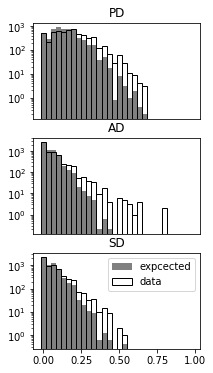

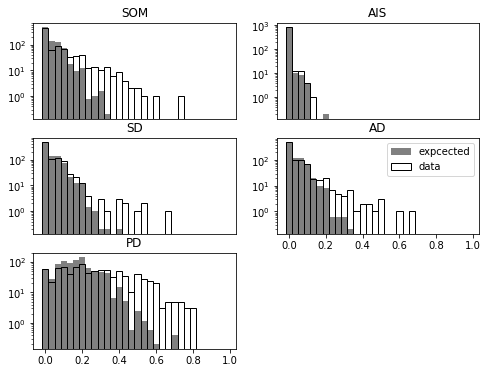

In [8]:
oversample_control = 5

def plot_single_panel(ax, data, ctrl, column_name):
    bins = numpy.linspace(0, 1, 31)
    H_data = numpy.histogram(data.res[column_name], bins=bins)[0]
    H_ctrl = (1.0 / oversample_control) * numpy.histogram(ctrl.res[column_name], bins=bins)[0]
    ax.bar(bins[:-1], H_ctrl, width=(bins[1] - bins[0]), color="grey", label="expcected")
    ax.bar(bins[:-1], H_data, width=(bins[1] - bins[0]), color="None", edgecolor='black', label="data")
    ax.set_title(column_name)
    ax.set_yscale('log')

def fig_4_e_f(data_exc, data_inh, bino_mdl_exc, bino_mdl_inh):
    from matplotlib import pyplot as plt
    
    bino_fit_exc = bino_mdl_exc.fit_all(targeting.trivial_fit)
    bino_fit_inh = bino_mdl_inh.fit_all(targeting.trivial_fit)
    data_fit_exc = data_exc.fit_all(targeting.trivial_fit)
    data_fit_inh = data_inh.fit_all(targeting.trivial_fit)
    
    print("""Overall means for the 'first hit' binomial model (should be about the same as the fitted values above):
    Excitatory (%):\n{res_exc}
    Inhibitory (%):\n{res_inh}\n""".format(res_exc=str(100*bino_fit_exc),
                                   res_inh=str(100*bino_fit_inh)))
    
    print("""To compare, here the mean for the data:
    Excitatory (%):\n{res_exc}
    Inhibitory (%):\n{res_inh}\n""".format(res_exc=str(100*data_fit_exc),
                                   res_inh=str(100*data_fit_inh)))
    
    data_exc = data_exc.normalized()
    data_inh = data_inh.normalized()
    bino_mdl_exc = bino_mdl_exc.normalized()
    bino_mdl_inh = bino_mdl_inh.normalized()
    
    i = 1
    fig = plt.figure(figsize=(3, 6))
    for col in data_exc.res.columns:
        if type_to_idx[col] >= 0:
            ax = plt.subplot(3, 1, i)
            plot_single_panel(ax, data_exc, bino_mdl_exc, col)
            if i < 3: ax.set_xticks([])
            if i == 3: plt.legend()
            i = i + 1
    i = 1
    fig = plt.figure(figsize=(8, 6))
    for col in data_inh.res.columns:
        if type_to_idx[col] >= 0:
            ax = plt.subplot(3, 2, i)
            plot_single_panel(ax, data_inh, bino_mdl_inh, col)
            if i < 4: ax.set_xticks([])
            if i == 4: plt.legend()
            i = i + 1


bino_mdl_exc = targeting.binomial_model(data_exc, targeting.first_hit_fit, oversample=oversample_control)
bino_mdl_inh = targeting.binomial_model(data_inh, targeting.first_hit_fit, oversample=oversample_control)
fig_4_e_f(data_exc, data_inh, bino_mdl_exc, bino_mdl_inh)
    

Next, recreate panel 4 g:

/usr/local/lib/python3.5/dist-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


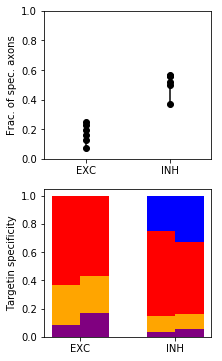

In [9]:
def plot_upper_panel(ax, sums_exc, sums_inh):
    ax.plot(numpy.zeros_like(sums_exc), sums_exc, marker='o', color='black')
    ax.plot(numpy.ones_like(sums_inh), sums_inh, marker='o', color='black')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['EXC', 'INH'])
    ax.set_ylabel('Frac. of spec. axons')
    ax.set_xlim([-0.5, 1.5])
    ax.set_ylim([0, 1])

def plot_lower_panel(ax, rel_exc, rel_inh):
    order_exc = ['SD', 'AD', 'PD']
    col_exc = ['purple', 'orange', 'red']
    order_inh = ['SD', 'AD', 'PD', 'AIS', 'SOM']
    col_inh = ['purple', 'orange', 'red', 'green', 'blue']
    rel_array_exc = numpy.array([[exc[k] for k in order_exc]
                                for exc in rel_exc])
    rel_array_inh = numpy.array([[inh[k] for k in order_inh]
                                for inh in rel_inh])

    x_exc = numpy.linspace(-0.3, 0.3, len(rel_array_exc) + 1)
    x_exc = 0.5 * (x_exc[1:] + x_exc[:-1])
    x_inh = numpy.linspace(0.7, 1.3, len(rel_array_inh) + 1)
    x_inh = 0.5 * (x_inh[1:] + x_inh[:-1])

    bottom = numpy.zeros(len(x_exc))
    for i in range(len(order_exc)):
        ax.bar(x_exc, rel_array_exc[:, i], bottom=bottom, color=col_exc[i], width=x_exc[1]-x_exc[0])
        bottom = bottom + rel_array_exc[:, i]

    bottom = numpy.zeros(len(x_inh))
    for i in range(len(order_inh)):
        ax.bar(x_inh, rel_array_inh[:, i], bottom=bottom, color=col_inh[i], width=x_inh[1]-x_inh[0])
        bottom = bottom + rel_array_inh[:, i]
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['EXC', 'INH'])
    ax.set_ylabel('Targetin specificity')
    

def fig_4_g(data_exc, data_inh, bino_mdl_exc, bino_mdl_inh, target_rates=[0.05, 0.1, 0.15, 0.2, 0.25, 0.3]):
    from matplotlib import pyplot as plt
    targeting_exc = [targeting.significant_targeting_fraction(data_exc, bino_mdl_exc, target_rate)
                     for target_rate in target_rates]
    targeting_inh = [targeting.significant_targeting_fraction(data_inh, bino_mdl_inh, target_rate)
                     for target_rate in target_rates]
    tgt_sum_exc = [numpy.sum(list(_tgt.values())) for _tgt in targeting_exc]
    tgt_sum_inh = [numpy.sum(list(_tgt.values())) for _tgt in targeting_inh]
    
    fig = plt.figure(figsize=(3, 6))
    ax = plt.subplot(2, 1, 1)
    plot_upper_panel(ax, tgt_sum_exc, tgt_sum_inh)
    rel_exc = [dict([(k, v / sm) for k, v in tgt.items()]) for tgt, sm in zip(targeting_exc, tgt_sum_exc)]
    rel_inh = [dict([(k, v / sm) for k, v in tgt.items()]) for tgt, sm in zip(targeting_inh, tgt_sum_inh)]

    plot_lower_panel(plt.subplot(2, 1, 2), (rel_exc[0], rel_exc[-1]), (rel_inh[0], rel_inh[-1]))

fig_4_g(data_exc, data_inh, bino_mdl_exc, bino_mdl_inh)

As a sanity check, we repeat the whole analysis with a negative control model: We use from the start a binomial model with the same average probabilities for each postsynaptic structures as the data. This control must yield the same results for "data" and "expected".

        Total probabilities add up to 1.3379045309207456.
        Adjusting probability values for 'OTHER' to compensate!


/home/reimann/code/targeting_specificity_test/targeting/specificity.py:21: RuntimeWarning: invalid value encountered in log
  return -numpy.sum(numpy.log(p_zero))


        Total probabilities add up to 1.4915262988875844.
        Adjusting probability values for 'OTHER' to compensate!
Generating panels 4 D, E, F and G for a negative control model that should show no indication of targeting!
Results of the 'first hit' binomial model fit:
    Excitatory (%):
PD    20.220765
AD     6.298139
SD     7.271549
dtype: float64
    Inhibitory (%):
SOM     6.917554
AIS     0.303161
SD      4.637481
AD      4.347017
PD     32.947417
dtype: float64
Overall means for the 'first hit' binomial model (should be about the same as the fitted values above):
    Excitatory (%):
PD       20.148897
AD        6.283607
SD        7.291561
OTHER    66.275935
dtype: float64
    Inhibitory (%):
SOM       6.969547
AIS       0.315534
SD        4.624201
AD        4.363069
PD       32.732087
OTHER    50.995563
dtype: float64

To compare, here the mean for the data:
    Excitatory (%):
PD       20.541846
AD        6.232072
SD        7.247168
OTHER    65.978914
dtype: float64
    

/usr/local/lib/python3.5/dist-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars


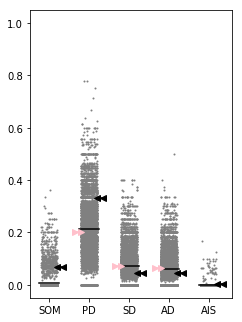

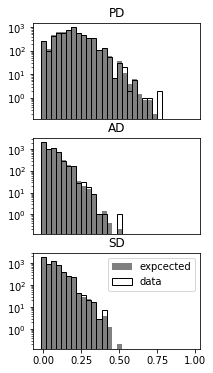

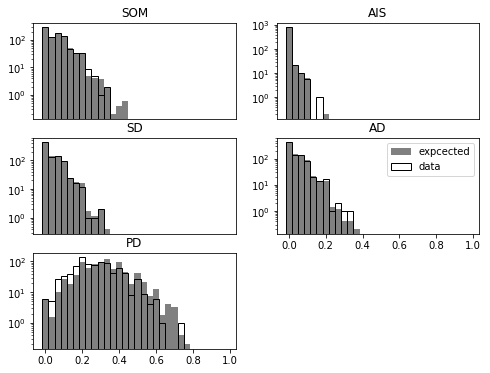

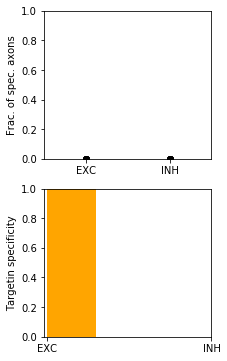

In [10]:
# The following generates a simple binomial model, fitting parameters of the model from the biological data.
negative_ctrl_exc = targeting.binomial_model(data_exc, targeting.trivial_fit)
negative_ctrl_inh = targeting.binomial_model(data_inh, targeting.trivial_fit)

# As before, we generate a binomial control model using the "first hit" model. As the negative control model above is
# a simple binomial model, the "first_hit" estimator will return the correct targeting probabilities and the analysis
# should show a negative result.
negative_ctrl_bino_exc = targeting.binomial_model(negative_ctrl_exc, targeting.first_hit_fit, oversample=oversample_control)
negative_ctrl_bino_inh = targeting.binomial_model(negative_ctrl_inh, targeting.first_hit_fit, oversample=oversample_control)

print("Generating panels 4 D, E, F and G for a negative control model that should show no indication of targeting!")

fig_4_d(negative_ctrl_exc, negative_ctrl_inh)
fig_4_e_f(negative_ctrl_exc, negative_ctrl_inh, negative_ctrl_bino_exc, negative_ctrl_bino_inh)
fig_4_g(negative_ctrl_exc, negative_ctrl_inh, negative_ctrl_bino_exc, negative_ctrl_bino_inh)

The sanity check was successful.

# A control model recreates the results *without* targeting specifity
However, I do not believe the authors interpretation of their results as indication of targeting specificity of individual axons is valid.

I developed a competing control model that recreates the results *without* any targeting specificity. The model works as follows:
First, it uses a binomial model with increased out-degrees (i.e. higher number of synapses per axon) to generate synapse 'candidates'. Then, it groups candidates that are targeting the same type of postsynaptic structure into groups of a specified size. Finally, each group of candidates is either accepted or rejected with a fixed, independent probability. Accepted groups lead to the formation of a synapse in this model. 

The acceptance probability is balanced with the increase of out-degrees in the initial binomial model, such that the final out-degrees match the reference model.

This is inspired by the following considerations: We can consider each time an axons gets close enough to a dendrite to theoretically form a synapse as a potential synapse or apposition. It has long been known that the number of potential synapses is much higher than the number of actual synapses. We explicitly recreate this hypothesis by first generating candidates, then accepting or rejecting them. Both processes are binomial without any specific targeting mechanisms.

The crucial thing that we are introducing is that we group a number of candidates (onto the same postsynaptic structure class) together and either accept or reject them together. This introduces statistical dependence between the first and further synapses onto a given postsynaptic structure class, but cannot be interpreted as a form of targeting.

100% (5877 of 5877) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (861 of 861) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


        Total probabilities add up to 0.5235864508718481.
        Adjusting probability values for 'OTHER' to compensate!
        Total probabilities add up to 0.5007929470465253.
        Adjusting probability values for 'OTHER' to compensate!
Generating panels 4 D, E, F and G for a candidate control model that might show indication of targeting!
Results of the 'first hit' binomial model fit:
    Excitatory (%):
PD    9.798534
AD    3.542399
SD    3.800837
dtype: float64
    Inhibitory (%):
SOM     4.046536
AIS     0.220819
SD      2.731748
AD      3.051188
PD     14.206606
dtype: float64
Overall means for the 'first hit' binomial model (should be about the same as the fitted values above):
    Excitatory (%):
PD        9.821125
AD        3.539126
SD        3.800231
OTHER    82.839518
dtype: float64
    Inhibitory (%):
SOM       4.129794
AIS       0.216827
SD        2.603182
AD        3.180546
PD       14.257620
OTHER    75.612031
dtype: float64

To compare, here the mean for the data:

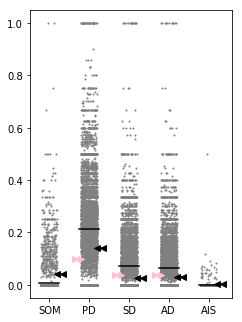

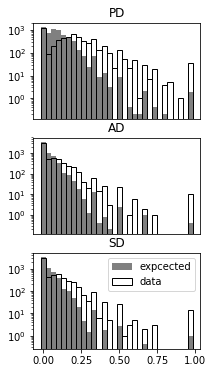

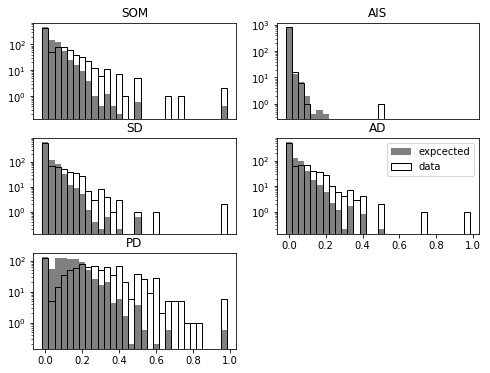

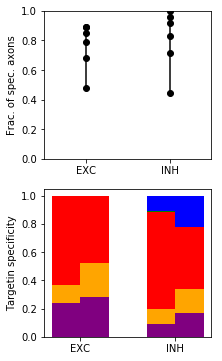

In [11]:
filling_fraction = 0.4
n_sampled_together = 3
# First, we create our model candidate to provide an alternative explanation for the findings.
# Most parameters for the candidate are fit from the biological data, others are set to reasonable estimates above.
cand_ctrl_exc = targeting.subsample_from_appositions_model(data_exc, targeting.trivial_fit,
                                                          filling_fraction, n_sampled_together)
cand_ctrl_inh = targeting.subsample_from_appositions_model(data_inh, targeting.trivial_fit,
                                                          filling_fraction, n_sampled_together)

# As for the previous analysis, Generate binomial model fits based on the "first hit" model.
cand_ctrl_bino_exc = targeting.binomial_model(cand_ctrl_exc, targeting.first_hit_fit, oversample=oversample_control)
cand_ctrl_bino_inh = targeting.binomial_model(cand_ctrl_inh, targeting.first_hit_fit, oversample=oversample_control)

print("Generating panels 4 D, E, F and G for a candidate control model that might show indication of targeting!")
fig_4_d(cand_ctrl_exc, cand_ctrl_inh)
fig_4_e_f(cand_ctrl_exc, cand_ctrl_inh, cand_ctrl_bino_exc, cand_ctrl_bino_inh)
fig_4_g(cand_ctrl_exc, cand_ctrl_inh, cand_ctrl_bino_exc, cand_ctrl_bino_inh)

One more sanity check of our "subsample_from_appositions" model. If we set n_sampled_together to 1, then candidates are grouped into groups of size one, i.e. they are not grouped at all. In that case, the model should be reducable to a simple binomial model and once again, in the result "data" and "expected" should be identical.

100% (5877 of 5877) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (861 of 861) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


        Total probabilities add up to 1.3340745556399791.
        Adjusting probability values for 'OTHER' to compensate!
        Total probabilities add up to 1.4610648778091662.
        Adjusting probability values for 'OTHER' to compensate!
Generating panels 4 D, E, F for a sanity check control that should not show indication of targeting!
Results of the 'first hit' binomial model fit:
    Excitatory (%):
PD    19.690839
AD     6.247616
SD     7.469001
dtype: float64
    Inhibitory (%):
SOM     6.812374
AIS     0.298052
SD      4.521104
AD      5.004118
PD     29.470839
dtype: float64
Overall means for the 'first hit' binomial model (should be about the same as the fitted values above):
    Excitatory (%):
PD       19.700871
AD        6.219306
SD        7.439959
OTHER    66.639865
dtype: float64
    Inhibitory (%):
SOM       6.617291
AIS       0.300034
SD        4.566663
AD        5.147832
PD       29.530931
OTHER    53.837249
dtype: float64

To compare, here the mean for the data:


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars


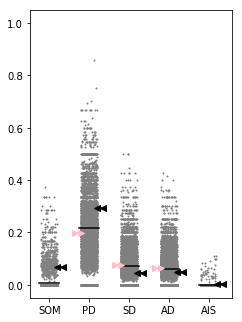

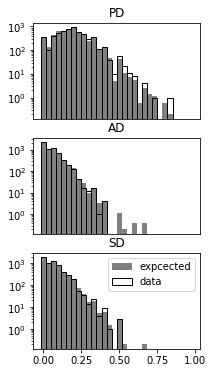

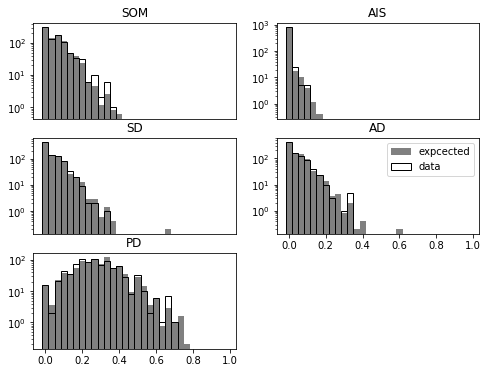

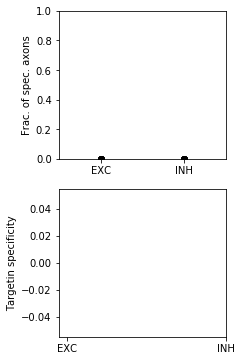

In [12]:
n_sampled_together = 1
# The following will generate a subsampling model where individual appositions are accepted or rejected. This can be reduced
# to a binomial model and will consequently result in a negative result.
cand_ctrl_exc = targeting.subsample_from_appositions_model(data_exc, targeting.trivial_fit,
                                                          filling_fraction, n_sampled_together)
cand_ctrl_inh = targeting.subsample_from_appositions_model(data_inh, targeting.trivial_fit,
                                                          filling_fraction, n_sampled_together)

cand_ctrl_bino_exc = targeting.binomial_model(cand_ctrl_exc, targeting.first_hit_fit, oversample=oversample_control)
cand_ctrl_bino_inh = targeting.binomial_model(cand_ctrl_inh, targeting.first_hit_fit, oversample=oversample_control)

print("Generating panels 4 D, E, F and G for a sanity check control that should not show indication of targeting!")
fig_4_d(cand_ctrl_exc, cand_ctrl_inh)
fig_4_e_f(cand_ctrl_exc, cand_ctrl_inh, cand_ctrl_bino_exc, cand_ctrl_bino_inh)
fig_4_g(cand_ctrl_exc, cand_ctrl_inh, cand_ctrl_bino_exc, cand_ctrl_bino_inh)